In [23]:
!pip install -q torch torchvision tqdm matplotlib scikit-image scipy
!pip install -q grad-cam

In [24]:
# Standard imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
import os
import pickle
from tqdm import tqdm
import random

# PyTorch GradCAM imports
from pytorch_grad_cam import GradCAM as PyTorchGradCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
batch_size = 64
image_size = 32
nc = 3  # Number of channels in the training images
nz = 100  # Size of z latent vector
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
num_epochs = 2 #150
lr = 0.0002
beta1 = 0.5  # Beta1 hyperparameter for Adam optimizer
lambda_gradcam = 1.0  # Weight for GradCAM loss

# Create output directory for results
os.makedirs('results', exist_ok=True)
print('done')

Using device: cuda
done


Files already downloaded and verified
Files already downloaded and verified


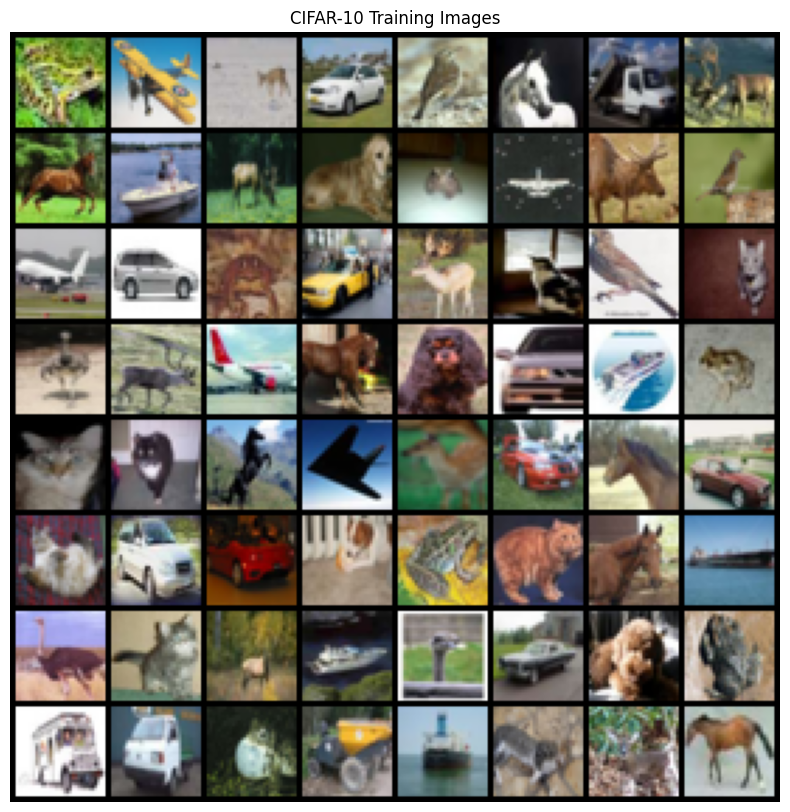

In [25]:
# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                              download=True, transform=transform)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                             download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

# Helper function to display images
def show_images(images, title=None):
    """Display a batch of images"""
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.imshow(np.transpose(make_grid(images, padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.show()

# Display some training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
show_images(images[:64], title='CIFAR-10 Training Images')

In [26]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_mobilenetv2_x1_0", pretrained=True)
print("Loaded Pretrained MobileNetV2 on CIFAR-10!")

model = model.to(device)
model.eval()

# Function to find the last conv layer in MobileNetV2
def get_last_conv_layer(model):
    # Get all modules in the model
    modules = list(model.named_modules())
    
    # Loop through modules in reverse order to find the last conv layer
    for name, module in reversed(modules):
        if isinstance(module, torch.nn.Conv2d):
            print(f"Found last conv layer: {name}")
            return module
    
    # If not found, return the last layer of features
    print("Using last feature layer as fallback")
    return model.features[-1]

# Get the last convolutional layer
last_conv_layer = get_last_conv_layer(model)

Loaded Pretrained MobileNetV2 on CIFAR-10!
Found last conv layer: features.18.0


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


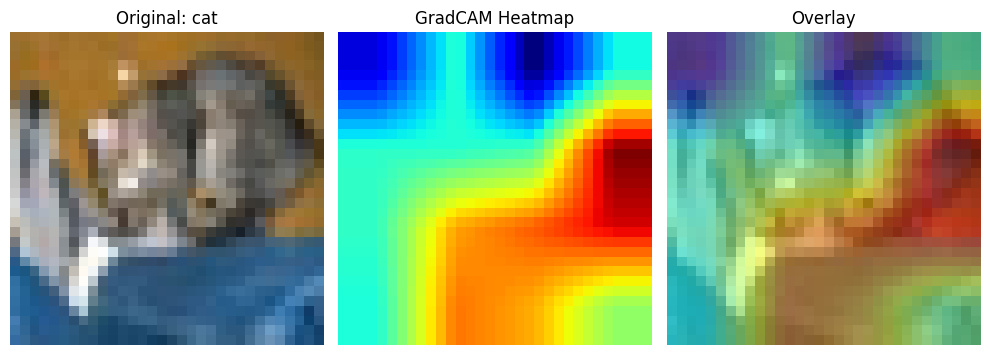

GradCAM test complete!


In [27]:
# Initialize GradCAM with the pre-trained model
# Note: Removed the use_cuda parameter that was causing the error
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

cam = GradCAM(
    model=model,  # Your pre-trained MobileNetV2
    target_layers=[last_conv_layer]  # The last conv layer you identified
)

# Function to generate Grad-CAM heatmaps
def generate_gradcam_heatmap(image, class_idx):
    try:
        # Detach from computation graph before converting to NumPy
        image_np = image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        # Normalize and preprocess for Grad-CAM
        input_tensor = preprocess_image(image_np, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        
        # Wrap class_idx properly
        target = [ClassifierOutputTarget(class_idx)]
        
        grayscale_cam = cam(input_tensor=input_tensor, targets=target)[0]
        return grayscale_cam
    except Exception as e:
        print(f"Error in generate_gradcam_heatmap: {e}")
        # Return a fallback heatmap (uniform distribution)
        return np.ones((32, 32), dtype=np.float32) * 0.5
        
# Function to visualize GradCAM heatmaps
def visualize_gradcam(model, images, labels=None, classes=None):
    """Visualize GradCAM heatmaps for a batch of images"""
    model.eval()
    plt.figure(figsize=(15, 4*len(images)))
    
    for i, image in enumerate(images):
        # Process image
        img_tensor = image.unsqueeze(0).to(device)
        
        # Get prediction if labels not provided
        if labels is None:
            with torch.no_grad():
                output = model(img_tensor)
                _, pred = torch.max(output, 1)
                pred = pred.item()
        else:
            # Just use the label directly - no need to call .item() as we already did that in main()
            pred = labels[i]
        
        # Generate heatmap
        heatmap = generate_gradcam_heatmap(img_tensor, pred)
        
        # Display original image
        plt.subplot(len(images), 3, i*3+1)
        plt.imshow(image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
        if classes:
            plt.title(f'Class: {classes[pred]}')
        else:
            plt.title(f'Class: {pred}')
        plt.axis('off')
        
        # Display heatmap
        plt.subplot(len(images), 3, i*3+2)
        plt.imshow(heatmap, cmap='jet')
        plt.title('GradCAM Heatmap')
        plt.axis('off')
        
        # Display overlay
        plt.subplot(len(images), 3, i*3+3)
        img_np = image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
        plt.imshow(img_np)
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
# Test the GradCAM function with a sample image
def test_gradcam():
    # Get a sample image
    test_batch = next(iter(testloader))
    test_image = test_batch[0][0].unsqueeze(0).to(device)
    test_label = test_batch[1][0].item()
    
    # Generate heatmap
    heatmap = generate_gradcam_heatmap(test_image, test_label)
    
    # Display the results
    plt.figure(figsize=(10, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    img_np = test_image.squeeze().cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
    plt.imshow(img_np)
    plt.title(f'Original: {classes[test_label]}')
    plt.axis('off')
    
    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title('GradCAM Heatmap')
    plt.axis('off')
    
    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(img_np)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title('Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("GradCAM test complete!")
    return heatmap

# Function to generate class-specific GradCAM heatmaps
def generate_class_heatmaps(model, dataloader, num_samples=50):
    """Generate and store GradCAM heatmaps for each class"""
    class_heatmaps = {i: [] for i in range(10)}  # 10 classes in CIFAR-10
    
    model.eval()
    count = {i: 0 for i in range(10)}
    
    for data in tqdm(dataloader, desc="Generating class heatmaps"):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        for i in range(images.size(0)):
            label = labels[i].item()
            
            if count[label] < num_samples:
                image = images[i:i+1]
                
                # Get prediction
                with torch.no_grad():
                    output = model(image)
                    _, predicted = torch.max(output, 1)
                
                # Only use correctly classified images
                if predicted.item() == label:
                    try:
                        # Generate heatmap
                        heatmap = generate_gradcam_heatmap(image, label)
                        
                        # Convert to tensor
                        heatmap_tensor = torch.from_numpy(heatmap).float().unsqueeze(0).unsqueeze(0)
                        
                        class_heatmaps[label].append(heatmap_tensor)
                        count[label] += 1
                    except Exception as e:
                        print(f"Error generating heatmap: {e}")
                        continue
        
        # Check if we have enough samples for each class
        if all(count[i] >= num_samples for i in range(10)):
            break
    
    print(f"Generated heatmaps: {[len(class_heatmaps[i]) for i in range(10)]}")
    return class_heatmaps
    
# Uncomment to test the GradCAM function
test_result = test_gradcam()

In [28]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input.view(-1, nz, 1, 1))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            # No Sigmoid here, will use BCEWithLogitsLoss
        )

    def forward(self, input):
        return self.main(input)

# Initialize networks
def initialize_networks():
    """Initialize Generator and Discriminator networks"""
    netG = Generator().to(device)
    netD = Discriminator().to(device)
    
    # Initialize weights
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    return netG, netD

In [29]:
# Custom function to compute SSIM loss
def ssim_loss(img1, img2):
    """Compute SSIM loss between two tensors (heatmaps)"""
    # Convert to numpy arrays for SSIM calculation
    img1_np = img1.detach().cpu().numpy().squeeze()
    img2_np = img2.detach().cpu().numpy().squeeze()
    
    # Calculate SSIM
    ssim_value = ssim(img1_np, img2_np, data_range=1.0)
    
    # Return 1 - SSIM as the loss (higher SSIM = lower loss)
    return 1.0 - ssim_value

# Custom function to compute Pearson correlation loss
def pearson_loss(img1, img2):
    """Compute Pearson correlation loss between two tensors (heatmaps)"""
    # Flatten tensors
    img1_flat = img1.view(-1).detach().cpu().numpy()
    img2_flat = img2.view(-1).detach().cpu().numpy()
    
    # Calculate Pearson correlation
    pearson_corr, _ = pearsonr(img1_flat, img2_flat)
    
    # Handle NaN values
    if np.isnan(pearson_corr):
        pearson_corr = 0.0
    
    # Return 1 - correlation as the loss (higher correlation = lower loss)
    return 1.0 - pearson_corr

# Function to compute GradCAM region emphasis loss
def gradcam_region_emphasis_loss(real_heatmap, fake_heatmap):
    """Compute combined GradCAM region emphasis loss"""
    # Compute SSIM and Pearson losses
    ssim_l = ssim_loss(real_heatmap, fake_heatmap)
    pearson_l = pearson_loss(real_heatmap, fake_heatmap)
    
    # Return average of both losses
    return 0.5 * (ssim_l + pearson_l)

In [30]:
# GAN Training with GradCAM (5-sample heatmap comparison)
def train_gan_with_gradcam(pretrained_model, class_heatmaps, netG, netD, num_epochs=50):
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    criterion = nn.BCEWithLogitsLoss()

    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    g_losses, d_losses, gc_losses = [], [], []

    for epoch in range(num_epochs):
        for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            real_images, real_labels = data
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # === Train Discriminator ===
            netD.zero_grad()
            label = torch.full((batch_size,), 1, dtype=torch.float, device=device)
            output = netD(real_images).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()

            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            label.fill_(0)
            output = netD(fake_images.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()

            errD = errD_real + errD_fake
            optimizerD.step()

            # === Train Generator ===
            netG.zero_grad()
            label.fill_(1)
            output = netD(fake_images).view(-1)
            errG_gan = criterion(output, label)

            pretrained_model.eval()
            with torch.no_grad():
                pred_logits = pretrained_model(fake_images)
                pred_classes = torch.argmax(pred_logits, dim=1)

            gradcam_loss_value = 0.0
            batch_with_heatmaps = 0

            for j in range(batch_size):
                pred_class = pred_classes[j].item()
                fake_image_single = fake_images[j:j+1]

                if class_heatmaps[pred_class] and len(class_heatmaps[pred_class]) >= 5:
                    try:
                        heatmap = generate_gradcam_heatmap(fake_image_single, pred_class)
                        fake_heatmap = torch.from_numpy(heatmap).float().unsqueeze(0).unsqueeze(0).to(device)

                        # Compare with 5 real heatmaps from the same class
                        real_heatmaps = random.sample(class_heatmaps[pred_class], k=5)
                        sample_losses = [gradcam_region_emphasis_loss(rh.to(device), fake_heatmap) for rh in real_heatmaps]
                        sample_loss = sum(sample_losses) / len(sample_losses)

                        gradcam_loss_value += sample_loss
                        batch_with_heatmaps += 1
                    except Exception as e:
                        print(f"skipping sample (heatmap error): {e}")
                        continue

            if batch_with_heatmaps > 0:
                gradcam_loss_value /= batch_with_heatmaps
                gc_losses.append(gradcam_loss_value)
            else:
                gradcam_loss_value = 0.0
                print("gradcam_loss_value is zero")

            errG = errG_gan + lambda_gradcam * gradcam_loss_value
            print(f"errG_gan: {errG_gan:.4f} | λ*GradCAM Loss: {(lambda_gradcam * gradcam_loss_value):.4f}")
            errG.backward()
            optimizerG.step()

            g_losses.append(errG.item())
            d_losses.append(errD.item())

            if i % 50 == 0:
                print(f"[{epoch+1}/{num_epochs}][{i}/{len(trainloader)}] "
                      f"Loss_D: {errD.item():.4f}, Loss_G: {errG.item():.4f}, GradCAM: {gradcam_loss_value:.4f}")

        if (epoch+1) % 5 == 0 or epoch == num_epochs-1:
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            save_image(make_grid(fake, padding=2, normalize=True), 
                       f'results/fake_samples_epoch_{epoch+1}.png')
            print(f"Saved samples at epoch {epoch+1}")

    torch.save(netG.state_dict(), 'results/generator.pth')
    torch.save(netD.state_dict(), 'results/discriminator.pth')

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    if gc_losses:
        plt.plot(gc_losses, label='GradCAM Loss')
        plt.xlabel('Iterations (valid GC)')
        plt.ylabel('GradCAM Loss')
        plt.legend()

    plt.tight_layout()
    plt.savefig('results/gan_loss_curves.png')
    plt.show()

    return netG, netD, g_losses, d_losses, gc_losses


In [31]:
# Evaluation and Visualization Functions
def compare_real_fake_heatmaps(pretrained_model, netG, testloader, classes, n_samples=8):
    """Compare GradCAM heatmaps between real and generated images using pre-trained model"""
    pretrained_model.eval()
    netG.eval()
    
    # Get a batch of real images
    real_batch = next(iter(testloader))
    real_images = real_batch[0][:n_samples].to(device)
    real_labels = real_batch[1][:n_samples].to(device)
    
    # Generate fake images
    noise = torch.randn(n_samples, nz, 1, 1, device=device)
    with torch.no_grad():
        fake_images = netG(noise)
    
    # Generate and compare heatmaps
    plt.figure(figsize=(16, 3*n_samples))
    
    for i in range(n_samples):
        # Real image
        real_image = real_images[i:i+1]
        real_label = real_labels[i].item()
        
        # Get prediction for real image
        with torch.no_grad():
            real_output = pretrained_model(real_image)
            _, real_pred = torch.max(real_output, 1)
            real_pred = real_pred.item()
        
        # Generate heatmap for real image
        real_heatmap = generate_gradcam_heatmap(real_image, real_pred)
        
        # Fake image
        fake_image = fake_images[i:i+1]
        
        # Get prediction for fake image
        with torch.no_grad():
            fake_output = pretrained_model(fake_image)
            _, fake_pred = torch.max(fake_output, 1)
            fake_pred = fake_pred.item()
        
        # Generate heatmap for fake image
        fake_heatmap = generate_gradcam_heatmap(fake_image, fake_pred)
        
        # Plot real image and its heatmap
        plt.subplot(n_samples, 4, i*4+1)
        plt.imshow(real_image.cpu().squeeze().permute(1, 2, 0).numpy() * 0.5 + 0.5)
        plt.title(f'Real: {classes[real_label]}\nPred: {classes[real_pred]}')
        plt.axis('off')
        
        plt.subplot(n_samples, 4, i*4+2)
        plt.imshow(real_heatmap, cmap='jet')
        plt.title('Real GradCAM')
        plt.axis('off')
        
        # Plot fake image and its heatmap
        plt.subplot(n_samples, 4, i*4+3)
        plt.imshow(fake_image.cpu().squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5)
        plt.title(f'Fake: {classes[fake_pred]}')
        plt.axis('off')
        
        plt.subplot(n_samples, 4, i*4+4)
        plt.imshow(fake_heatmap, cmap='jet')
        plt.title('Fake GradCAM')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('results/gradcam_comparison.png')
    plt.show()
    
    return real_images, fake_images

# Function to calculate metrics between real and fake heatmaps
def calculate_heatmap_metrics(pretrained_model, real_images, fake_images, n_samples=100):
    """Calculate metrics between real and fake GradCAM heatmaps"""
    pretrained_model.eval()
    
    ssim_values = []
    pearson_values = []
    
    for i in range(min(len(real_images), len(fake_images), n_samples)):
        try:
            # Real image
            real_image = real_images[i:i+1].to(device)
            
            # Get prediction for real image
            with torch.no_grad():
                real_output = pretrained_model(real_image)
                _, real_pred = torch.max(real_output, 1)
                real_pred = real_pred.item()
            
            # Generate heatmap for real image
            real_heatmap_np = generate_gradcam_heatmap(real_image, real_pred)
            real_heatmap = torch.from_numpy(real_heatmap_np).float().unsqueeze(0).unsqueeze(0)
            
            # Fake image
            fake_image = fake_images[i:i+1].to(device)
            
            # Generate heatmap for fake image - use same class as real for comparison
            fake_heatmap_np = generate_gradcam_heatmap(fake_image, real_pred)
            fake_heatmap = torch.from_numpy(fake_heatmap_np).float().unsqueeze(0).unsqueeze(0)
            
            # Calculate metrics
            ssim_val = 1.0 - ssim_loss(real_heatmap, fake_heatmap)  # Convert loss to similarity
            pearson_val = 1.0 - pearson_loss(real_heatmap, fake_heatmap)  # Convert loss to similarity
            
            ssim_values.append(ssim_val)
            pearson_values.append(pearson_val)
        except Exception as e:
            print(f"Error calculating metrics for sample {i}: {e}")
            continue
    
    # Calculate statistics
    if ssim_values and pearson_values:
        ssim_mean = np.mean(ssim_values)
        ssim_std = np.std(ssim_values)
        pearson_mean = np.mean(pearson_values)
        pearson_std = np.std(pearson_values)
        
        print(f"SSIM: Mean = {ssim_mean:.4f}, Std = {ssim_std:.4f}")
        print(f"Pearson Correlation: Mean = {pearson_mean:.4f}, Std = {pearson_std:.4f}")
        
        # Plot histogram of values
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(ssim_values, bins=20, alpha=0.7)
        plt.axvline(ssim_mean, color='r', linestyle='dashed', linewidth=1)
        plt.title(f'SSIM Values: Mean = {ssim_mean:.4f}')
        plt.xlabel('SSIM (higher is better)')
        plt.ylabel('Frequency')
        
        plt.subplot(1, 2, 2)
        plt.hist(pearson_values, bins=20, alpha=0.7)
        plt.axvline(pearson_mean, color='r', linestyle='dashed', linewidth=1)
        plt.title(f'Pearson Values: Mean = {pearson_mean:.4f}')
        plt.xlabel('Pearson Correlation (higher is better)')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.savefig('results/heatmap_metrics.png')
        plt.show()
        
        return {
            'ssim_mean': ssim_mean,
            'ssim_std': ssim_std,
            'pearson_mean': pearson_mean,
            'pearson_std': pearson_std,
            'ssim_values': ssim_values,
            'pearson_values': pearson_values
        }
    else:
        print("Not enough valid samples to calculate metrics")
        return None

# Function to generate samples with the trained generator
def generate_samples(netG, n_samples=100, n_display=64):
    """Generate samples using the trained generator"""
    netG.eval()
    
    # Generate images
    noise = torch.randn(n_samples, nz, 1, 1, device=device)
    with torch.no_grad():
        fake_images = netG(noise).detach().cpu()
    
    # Display a subset of generated images
    if n_display > 0:
        plt.figure(figsize=(10, 10))
        plt.axis('off')
        plt.title(f"{n_display} Generated Images")
        plt.imshow(np.transpose(make_grid(fake_images[:n_display], 
                                        padding=2, normalize=True), (1, 2, 0)))
        plt.savefig('results/final_samples.png')
        plt.show()
    
    return fake_images

In [32]:
# Main execution function
def main():

    print("Step 1: Setting up pre-trained classifier")
    # Pre-trained model and GradCAM are already set up (model & cam variables)
    
    print("Step 2: Testing GradCAM visualization")
    # Test GradCAM with a few images
    test_batch = next(iter(testloader))
    test_images, test_labels = test_batch
    
    # Convert tensor labels to Python integers before passing to visualize_gradcam
    test_labels_list = [label.item() for label in test_labels[:5]]
    visualize_gradcam(model, test_images[:5], test_labels_list, classes)
    
    print("Step 3: Generating Class-Specific GradCAM Heatmaps")
    # Try loading existing heatmaps first
    try:
        with open('results/class_heatmaps.pkl', 'rb') as f:
            class_heatmaps = pickle.load(f)
        print("Loaded existing heatmaps from disk")
    except:
        print("Generating new heatmaps")
        class_heatmaps = generate_class_heatmaps(model, trainloader, num_samples=50)
        # Save heatmaps to avoid regenerating them
        os.makedirs('results', exist_ok=True)
        with open('results/class_heatmaps.pkl', 'wb') as f:
            pickle.dump(class_heatmaps, f)
        print("Saved heatmaps to disk")
    
    print("Step 4: Initializing GAN Networks")
    netG, netD = initialize_networks()
    
    print("Step 5: Training GAN with GradCAM Guidance")
    # You can adjust the number of epochs based on your computational resources
    netG, netD, g_losses, d_losses, gc_losses = train_gan_with_gradcam(
        model, class_heatmaps, netG, netD, num_epochs=num_epochs)
    
    print("Step 6: Evaluating GAN with GradCAM")
    real_images, fake_images = compare_real_fake_heatmaps(model, netG, testloader, classes)
    metrics = calculate_heatmap_metrics(model, real_images, fake_images)
    
    print("Step 7: Generating Final Samples")
    generated_samples = generate_samples(netG, n_samples=100)
    
    print("All steps completed!")

Step 1: Setting up pre-trained classifier
Step 2: Testing GradCAM visualization


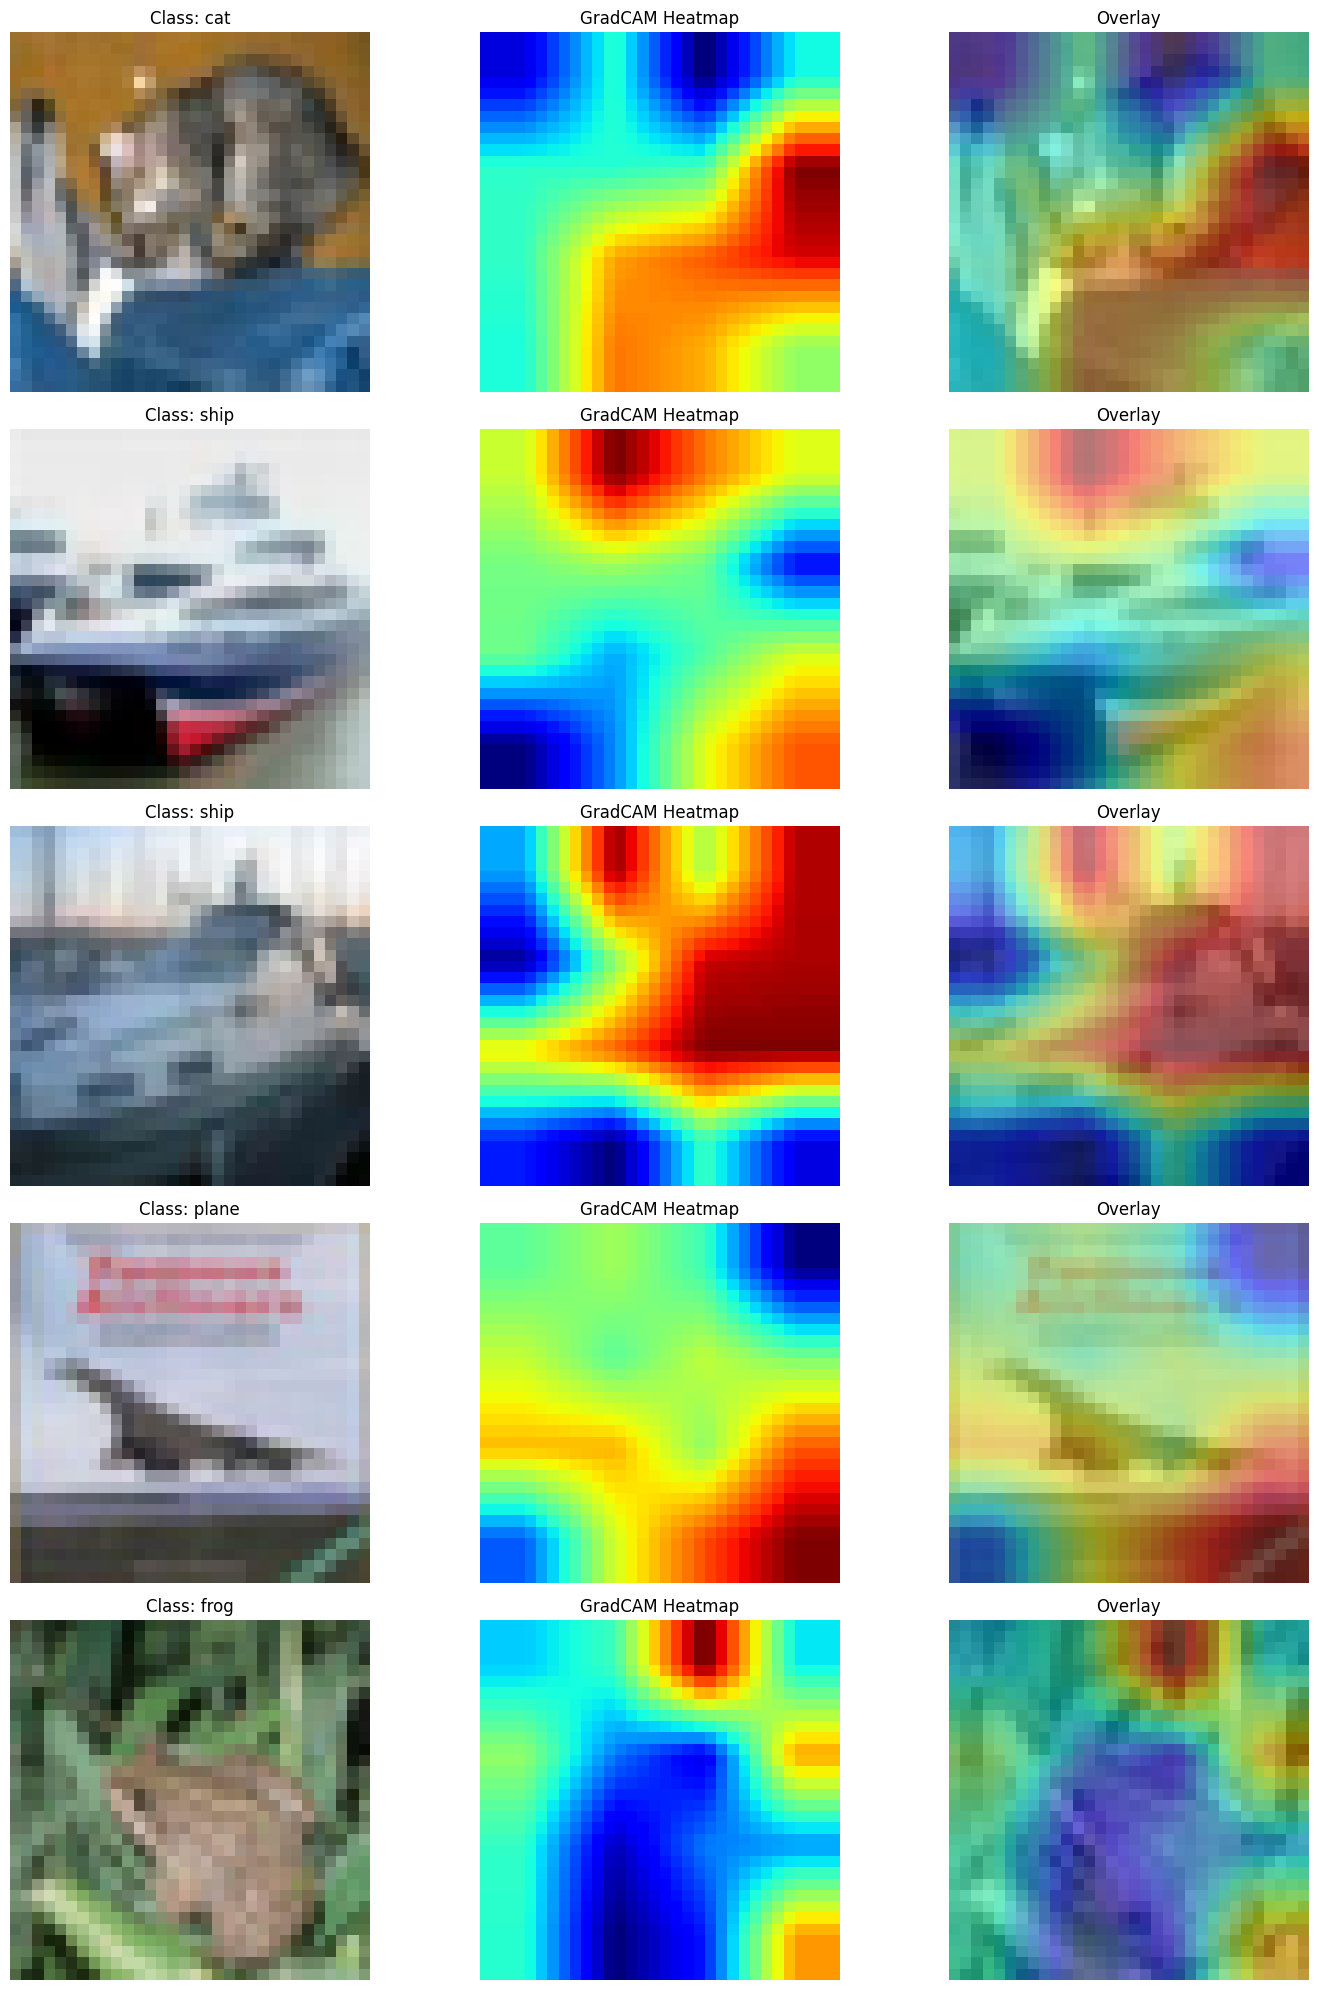

Step 3: Generating Class-Specific GradCAM Heatmaps
Loaded existing heatmaps from disk
Step 4: Initializing GAN Networks
Step 5: Training GAN with GradCAM Guidance


Epoch 1/2:   0%|          | 1/782 [00:01<20:45,  1.60s/it]

errG_gan: 2.2394 | λ*GradCAM Loss: 0.9284
[1/2][0/782] Loss_D: 1.4771, Loss_G: 3.1678, GradCAM: 0.9284


Epoch 1/2:   0%|          | 2/782 [00:03<19:19,  1.49s/it]

errG_gan: 1.5138 | λ*GradCAM Loss: 0.8885


Epoch 1/2:   0%|          | 3/782 [00:04<18:43,  1.44s/it]

errG_gan: 1.5103 | λ*GradCAM Loss: 0.8789


Epoch 1/2:   1%|          | 4/782 [00:05<18:20,  1.41s/it]

errG_gan: 2.2413 | λ*GradCAM Loss: 0.9059


Epoch 1/2:   1%|          | 5/782 [00:07<18:13,  1.41s/it]

errG_gan: 2.6828 | λ*GradCAM Loss: 0.8982


Epoch 1/2:   1%|          | 6/782 [00:08<18:02,  1.40s/it]

errG_gan: 2.8619 | λ*GradCAM Loss: 0.9023


Epoch 1/2:   1%|          | 7/782 [00:09<17:57,  1.39s/it]

errG_gan: 2.8548 | λ*GradCAM Loss: 0.9495


Epoch 1/2:   1%|          | 8/782 [00:11<17:47,  1.38s/it]

errG_gan: 3.3325 | λ*GradCAM Loss: 0.9650


Epoch 1/2:   1%|          | 9/782 [00:12<17:52,  1.39s/it]

errG_gan: 3.8028 | λ*GradCAM Loss: 0.9044


Epoch 1/2:   1%|▏         | 10/782 [00:14<17:47,  1.38s/it]

errG_gan: 3.8606 | λ*GradCAM Loss: 0.9371


Epoch 1/2:   1%|▏         | 11/782 [00:15<17:41,  1.38s/it]

errG_gan: 3.8450 | λ*GradCAM Loss: 0.9741


Epoch 1/2:   2%|▏         | 12/782 [00:16<17:38,  1.37s/it]

errG_gan: 3.7134 | λ*GradCAM Loss: 0.9293


Epoch 1/2:   2%|▏         | 13/782 [00:18<17:39,  1.38s/it]

errG_gan: 3.7521 | λ*GradCAM Loss: 0.9708


Epoch 1/2:   2%|▏         | 14/782 [00:19<17:41,  1.38s/it]

errG_gan: 4.2204 | λ*GradCAM Loss: 0.9985


Epoch 1/2:   2%|▏         | 15/782 [00:20<17:44,  1.39s/it]

errG_gan: 4.5570 | λ*GradCAM Loss: 1.0351


Epoch 1/2:   2%|▏         | 16/782 [00:22<17:48,  1.39s/it]

errG_gan: 4.2501 | λ*GradCAM Loss: 1.0641


Epoch 1/2:   2%|▏         | 17/782 [00:23<17:39,  1.39s/it]

errG_gan: 4.3635 | λ*GradCAM Loss: 1.0690


Epoch 1/2:   2%|▏         | 18/782 [00:25<17:38,  1.39s/it]

errG_gan: 4.7880 | λ*GradCAM Loss: 1.0034


Epoch 1/2:   2%|▏         | 19/782 [00:26<17:31,  1.38s/it]

errG_gan: 5.1263 | λ*GradCAM Loss: 1.0327


Epoch 1/2:   3%|▎         | 20/782 [00:27<17:36,  1.39s/it]

errG_gan: 5.0060 | λ*GradCAM Loss: 1.0239


Epoch 1/2:   3%|▎         | 21/782 [00:29<17:35,  1.39s/it]

errG_gan: 4.9682 | λ*GradCAM Loss: 0.9833


Epoch 1/2:   3%|▎         | 22/782 [00:30<17:58,  1.42s/it]

errG_gan: 5.3058 | λ*GradCAM Loss: 0.9412


Epoch 1/2:   3%|▎         | 23/782 [00:32<18:42,  1.48s/it]

errG_gan: 5.3988 | λ*GradCAM Loss: 0.9107


Epoch 1/2:   3%|▎         | 24/782 [00:33<18:26,  1.46s/it]

errG_gan: 5.1819 | λ*GradCAM Loss: 0.9099


Epoch 1/2:   3%|▎         | 25/782 [00:35<18:11,  1.44s/it]

errG_gan: 5.1737 | λ*GradCAM Loss: 0.8492


Epoch 1/2:   3%|▎         | 26/782 [00:36<18:02,  1.43s/it]

errG_gan: 5.1712 | λ*GradCAM Loss: 0.8712


Epoch 1/2:   3%|▎         | 27/782 [00:37<17:45,  1.41s/it]

errG_gan: 5.3983 | λ*GradCAM Loss: 0.8237


Epoch 1/2:   4%|▎         | 28/782 [00:39<17:35,  1.40s/it]

errG_gan: 5.7681 | λ*GradCAM Loss: 0.7701


Epoch 1/2:   4%|▎         | 29/782 [00:40<17:27,  1.39s/it]

errG_gan: 5.7739 | λ*GradCAM Loss: 0.8006


Epoch 1/2:   4%|▍         | 30/782 [00:42<17:34,  1.40s/it]

errG_gan: 5.4087 | λ*GradCAM Loss: 0.8386


Epoch 1/2:   4%|▍         | 31/782 [00:43<17:26,  1.39s/it]

errG_gan: 5.3721 | λ*GradCAM Loss: 0.9038


Epoch 1/2:   4%|▍         | 32/782 [00:44<17:16,  1.38s/it]

errG_gan: 5.4026 | λ*GradCAM Loss: 0.9189


Epoch 1/2:   4%|▍         | 33/782 [00:46<17:14,  1.38s/it]

errG_gan: 5.3299 | λ*GradCAM Loss: 0.9819


Epoch 1/2:   4%|▍         | 34/782 [00:47<17:09,  1.38s/it]

errG_gan: 5.5357 | λ*GradCAM Loss: 0.9760


Epoch 1/2:   4%|▍         | 35/782 [00:49<17:10,  1.38s/it]

errG_gan: 5.2487 | λ*GradCAM Loss: 0.9228


Epoch 1/2:   5%|▍         | 36/782 [00:50<17:05,  1.37s/it]

errG_gan: 4.9471 | λ*GradCAM Loss: 0.8958


Epoch 1/2:   5%|▍         | 37/782 [00:51<17:17,  1.39s/it]

errG_gan: 5.2368 | λ*GradCAM Loss: 0.8328


Epoch 1/2:   5%|▍         | 38/782 [00:53<17:13,  1.39s/it]

errG_gan: 5.3988 | λ*GradCAM Loss: 0.8088


Epoch 1/2:   5%|▍         | 39/782 [00:54<17:06,  1.38s/it]

errG_gan: 5.6061 | λ*GradCAM Loss: 0.8706


Epoch 1/2:   5%|▌         | 40/782 [00:55<17:02,  1.38s/it]

errG_gan: 5.5035 | λ*GradCAM Loss: 0.9082


Epoch 1/2:   5%|▌         | 41/782 [00:57<16:57,  1.37s/it]

errG_gan: 5.1499 | λ*GradCAM Loss: 0.9668


Epoch 1/2:   5%|▌         | 42/782 [00:58<16:57,  1.38s/it]

errG_gan: 5.1511 | λ*GradCAM Loss: 0.9538


Epoch 1/2:   5%|▌         | 43/782 [01:00<16:57,  1.38s/it]

errG_gan: 5.1251 | λ*GradCAM Loss: 0.9278


Epoch 1/2:   6%|▌         | 44/782 [01:01<17:02,  1.39s/it]

errG_gan: 5.4793 | λ*GradCAM Loss: 0.9400


Epoch 1/2:   6%|▌         | 45/782 [01:02<17:37,  1.43s/it]

errG_gan: 5.4470 | λ*GradCAM Loss: 0.9656


Epoch 1/2:   6%|▌         | 46/782 [01:04<17:29,  1.43s/it]

errG_gan: 5.1595 | λ*GradCAM Loss: 0.9176


Epoch 1/2:   6%|▌         | 47/782 [01:05<17:15,  1.41s/it]

errG_gan: 5.4965 | λ*GradCAM Loss: 0.9297


Epoch 1/2:   6%|▌         | 48/782 [01:07<17:11,  1.41s/it]

errG_gan: 5.6491 | λ*GradCAM Loss: 0.8766


Epoch 1/2:   6%|▋         | 49/782 [01:08<17:04,  1.40s/it]

errG_gan: 5.4414 | λ*GradCAM Loss: 0.9064


Epoch 1/2:   6%|▋         | 50/782 [01:09<17:00,  1.39s/it]

errG_gan: 5.6013 | λ*GradCAM Loss: 0.9121


Epoch 1/2:   7%|▋         | 51/782 [01:11<16:53,  1.39s/it]

errG_gan: 5.5878 | λ*GradCAM Loss: 0.9052
[1/2][50/782] Loss_D: 0.2850, Loss_G: 6.4931, GradCAM: 0.9052


Epoch 1/2:   7%|▋         | 52/782 [01:12<16:53,  1.39s/it]

errG_gan: 5.2563 | λ*GradCAM Loss: 0.9349


Epoch 1/2:   7%|▋         | 53/782 [01:14<16:51,  1.39s/it]

errG_gan: 4.8694 | λ*GradCAM Loss: 0.9135


Epoch 1/2:   7%|▋         | 54/782 [01:15<16:57,  1.40s/it]

errG_gan: 5.0973 | λ*GradCAM Loss: 0.9294


Epoch 1/2:   7%|▋         | 55/782 [01:16<16:58,  1.40s/it]

errG_gan: 5.3089 | λ*GradCAM Loss: 0.9070


Epoch 1/2:   7%|▋         | 56/782 [01:18<17:02,  1.41s/it]

errG_gan: 5.2824 | λ*GradCAM Loss: 0.9606


Epoch 1/2:   7%|▋         | 57/782 [01:19<17:00,  1.41s/it]

errG_gan: 5.5224 | λ*GradCAM Loss: 0.9243


Epoch 1/2:   7%|▋         | 58/782 [01:21<16:58,  1.41s/it]

errG_gan: 5.5790 | λ*GradCAM Loss: 0.8938


Epoch 1/2:   8%|▊         | 59/782 [01:22<17:01,  1.41s/it]

errG_gan: 5.5824 | λ*GradCAM Loss: 0.8631


Epoch 1/2:   8%|▊         | 60/782 [01:23<16:57,  1.41s/it]

errG_gan: 5.7175 | λ*GradCAM Loss: 0.8748


Epoch 1/2:   8%|▊         | 61/782 [01:25<16:53,  1.41s/it]

errG_gan: 5.6973 | λ*GradCAM Loss: 0.8809


Epoch 1/2:   8%|▊         | 62/782 [01:26<16:52,  1.41s/it]

errG_gan: 5.4284 | λ*GradCAM Loss: 0.8719


Epoch 1/2:   8%|▊         | 63/782 [01:28<16:47,  1.40s/it]

errG_gan: 5.5032 | λ*GradCAM Loss: 0.8553


Epoch 1/2:   8%|▊         | 63/782 [01:29<16:57,  1.41s/it]


KeyboardInterrupt: 

In [33]:
main()